## <font color=green> <center> Mall Customer Segmentation - A Clustering Algorithm based Approach </font> </center>


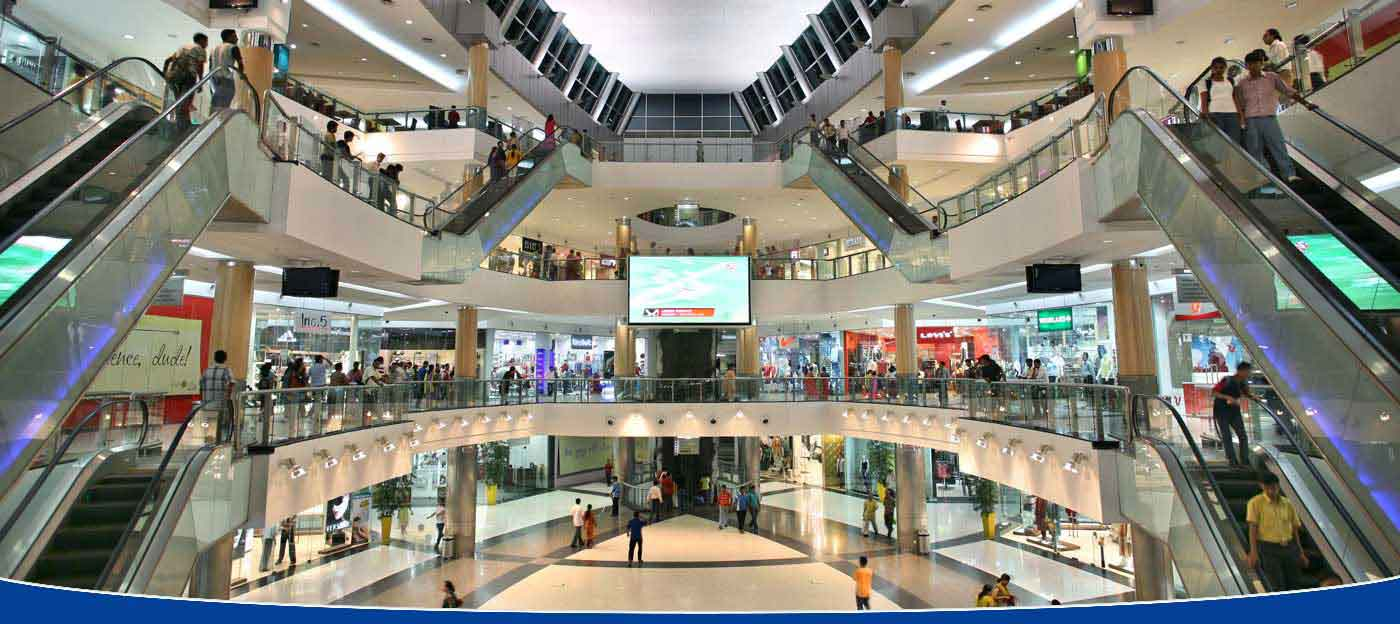

## <font color=blue> About the dataset: </font>

### The dataset gives an account of mall customers and are categorised based on their age, gender, Annual Income, and spending score.

## <font color=blue> Goal of the Project: </font>

### - The project aims to check for visible patterns in the data. 
### - The aim is to find visible clusters amongst the data points and segment them into actionable clusters.
### - The project also aims to run multiple clustering algorithm and try to check which algorithm gives a cluster which has a lesser intra-cluster distance and greater inter-cluster distance.

### <font color=blue> Loading necessary libraries </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.cluster import DBSCAN


import warnings
warnings.filterwarnings("ignore")

### <font color=blue> Loading dataset </font>

In [2]:
df = pd.read_csv("Mall_Customers.csv")

### <font color=blue> Enquiry into the Dataset </font>

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**CustomerID is not required in our segmentation, hence let's drop it.**

In [8]:
df = df.drop("CustomerID", axis=1)

## <font color=blue> Data Visualization </font>

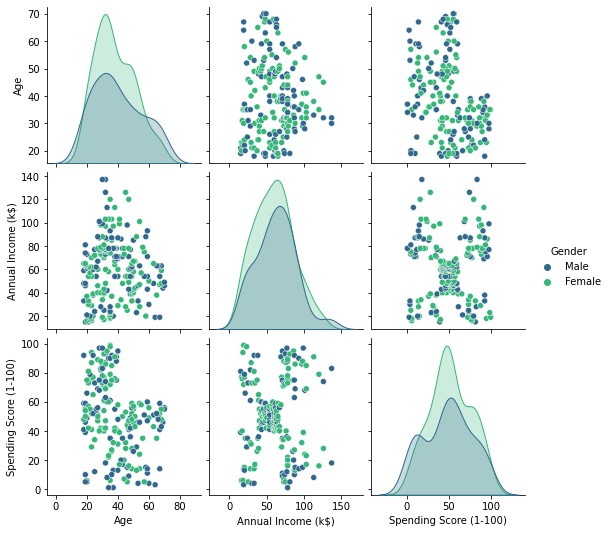

In [9]:
sns.pairplot(df, hue="Gender", palette="viridis")

## <font color=blue> Feature Engineering </font>

**From the pairplot it is quite evident that gender plays no major role in determining the clusters**

In [10]:
df = df.drop("Gender", axis=1)

### <font color=blue> Data Scaling </font>

In [11]:
scaler=MinMaxScaler()

In [12]:
X=df

In [13]:
X=scaler.fit_transform(X)
X = pd.DataFrame(X,columns=df.columns)

## <span style="color:blue">Assessing Clustering Tendency</span>


Before applying any clustering method on the data, it’s important to evaluate whether the data sets contains meaningful clusters (i.e.: non-random structures) or not. If yes, then how many clusters are there. This process is defined as the assessing of clustering tendency or the feasibility of the clustering analysis.

A big issue, in cluster analysis, is that clustering methods will return clusters even if the data does not contain any clusters. In other words, if you blindly apply a clustering method on a data set, it will divide the data into clusters because that is what it supposed to do

### <font color=blue> The Hopkins Statistic </font>

**The Hopkins statistic** (Lawson and Jurs 1990) is used to assess the clustering tendency of a data set by measuring the probability that a given data set is generated by a uniform data distribution. In other words, it tests the spatial randomness of the data. It is based on the difference between the distance from a real point to its nearest neighbor, U, and the distance from a randomly chosen point within thedata space to the nearest real data point, W.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bacbd9fd135fd889a9c25feca3ac6762b34762f8" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -3.005ex; width:25.886ex; height:7.176ex;" alt="{\displaystyle H={\frac {\sum _{i=1}^{m}{u_{i}^{d}}}{\sum _{i=1}^{m}{u_{i}^{d}}+\sum _{i=1}^{m}{w_{i}^{d}}}}\,}">



**The null and the alternative hypotheses are defined as follow:**

Null hypothesis: the data set D is uniformly distributed (i.e., no meaningful clusters)

Alternative hypothesis: the data set D is not uniformly distributed (i.e., contains meaningful clusters)

Put in other words, If the value of Hopkins statistic is close to 1, then we can reject the null hypothesis and conclude that the dataset D is significantly a clusterable data. 

A value for H higher than 0.75 indicates a clustering tendency at the 90% confidence level.

[Source](https://www.datanovia.com/en/lessons/assessing-clustering-tendency/)

In [14]:
# Let's create a function to find the hopkins_statistic for a dataframe
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbour searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [15]:
hopkins_statistic(X)
print(f"The Hopkins_statistic for the dataset : {hopkins_statistic(X)}.")

The Hopkins_statistic for the dataset : 0.7471502318914884.


The data shows a acceptable value of Hopkins Statistic and hence the data has a tendency to form clusters.

## <font color=green> Model Building </font>

## <font color=blue> K-Means Clustering </font>

### The Algorithm

K-Means is one of the simplest unsupervised clustering algorithm which is used to cluster our data into K number of clusters. The algorithm iteratively assigns the data points to one of the K clusters based on how near the point is to the cluster centroid. 

The result of K-Means algorithm is:

- K number of cluster centroids
- Data points classified into the clusters

Assuming we have input data points x1,x2,x3,…,xn and value of K (the number of clusters needed). We follow the below procedure:

- Pick K points as the initial centroids from the dataset, either randomly or the first K.
- Find the Euclidean distance of each point in the dataset with the identified K points (cluster centroids).
- Assign each data point to the closest centroid using the distance found in the previous step.
- Find the new centroid by taking the average of the points in each cluster group.
- Repeat 2 to 4 for a fixed number of iteration or till the centroids don’t change.

Euclidean Distance between two points in space:
If p = (p1, p2) and q = (q1, q2) then the distance is given by

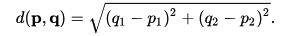

Assigning each point to the nearest cluster:
If each cluster centroid is denoted by ci, then each data point x is assigned to a cluster based on

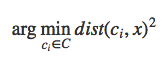

here dist() is the euclidean distance.

Finding the new centroid from the clustered group of points:
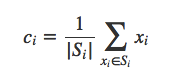    

Si is the set of all points assigned to the ith cluster.

[Source](https://muthu.co/mathematics-behind-k-mean-clustering-algorithm/)

#### To find the value of K to be used in our analysis, we will use the elbow curve method.

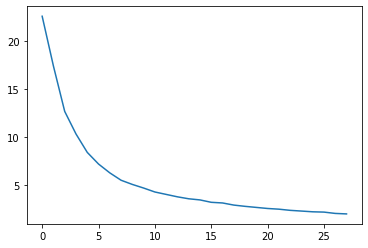

In [16]:
ssd=[] # a list to store the squared sum of distances
for n in range(2,30):
    kmeans = KMeans(n_clusters=n, max_iter=50)
    kmeans.fit(X)
    
    ssd.append(kmeans.inertia_) 

# plot the SSDs for each n_clusters
plt.plot(ssd)

#### From the above elbow curve it is evident that choosing 5 as the estimate for K would be a safe approach.

In [18]:
kmeans = KMeans(n_clusters=5, max_iter=50, random_state=5)
kmeans.fit(X)

KMeans(max_iter=50, n_clusters=5, random_state=5)

In [19]:
kmeans.labels_

array([0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 3, 0, 3,
       1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3,
       1, 3, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 4, 4, 0, 4, 2, 4, 2, 4, 2, 4,
       0, 4, 0, 4, 2, 4, 0, 4, 2, 4, 0, 4, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 1, 4, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4])

In [20]:
X['cluster_id'] = kmeans.labels_
X.head()

,Age,Annual Income (k$),Spending Score (1-100),cluster_id
0,0.019231,0.000000,0.387755,0
1,0.057692,0.000000,0.816327,3
2,0.038462,0.008197,0.051020,0
3,0.096154,0.008197,0.775510,3
4,0.250000,0.016393,0.397959,0


### <font color=blue> Cluster Visualization </font>

**Let's plot a box plot and scatterplot to see if their is any actual variation within the cluster labels.**


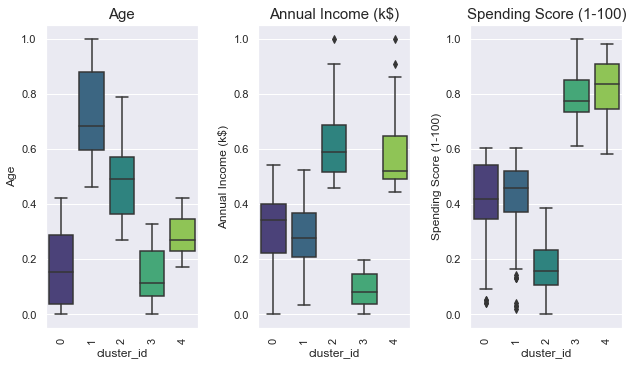

In [21]:
fig = plt.figure(figsize=(10,20))
sns.set(font_scale=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(len(X.columns)-1):
    plt.subplot(3,3, i + 1)
    ax=sns.boxplot(y=X.columns[i], x='cluster_id', data=X,palette = 'viridis')
    ax.set_title(str(X.columns[i]), fontsize=15)
    plt.xticks(rotation=90)
fig.show()

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

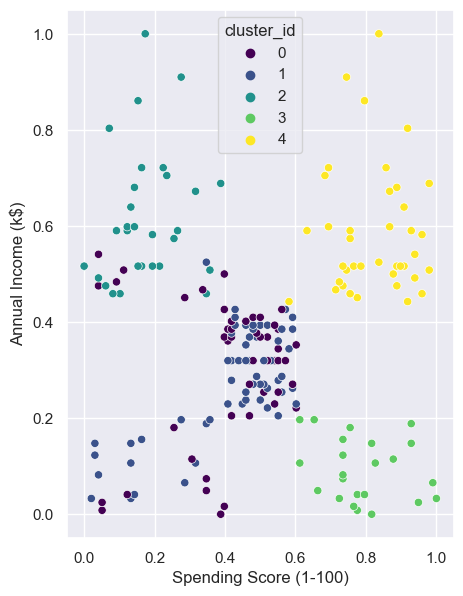

In [22]:
plt.figure(figsize=(5,7), dpi=100)
sns.scatterplot(data=X, y="Annual Income (k$)",x="Spending Score (1-100)", hue="cluster_id", palette="viridis")

### <font color=blue> Model Evaluation </font>

#### -  Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall like in the case of supervised learning algorithms.

####  -  Here clusters are evaluated based on some similarity or dissimilarity measure such as the distance between cluster points. 

#### -  If the clustering algorithm separates dissimilar observations apart and similar observations together, then it has performed well. 
####  -  In this project, one of the most popular approach, Silhouette Analysis has been used to evaluate the clustering Models.

### <font color=blue> Silhouette Analysis </font>

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [23]:
cluster_labels = kmeans.labels_
silhouette_avg_K = round(silhouette_score(X, cluster_labels),4) #computing the silhouette score for the K-Means Model.
print(f"For K- Means Model with n_clusters=5, the silhouette score is {silhouette_avg_K}")

For K- Means Model with n_clusters=5, the silhouette score is 0.7504


## <font color=blue> Hierarchical Clustering </font>

### The Algorithm
Hierarchical clustering treats each data point as a singleton cluster, and then successively merges clusters until all points have been merged into a single remaining cluster. A hierarchical clustering is often represented as a dendrogram (from Manning et al. 1999). 

[Source](http://www.saedsayad.com/clustering_hierarchical.htm)

Before any clustering is performed, it is required to determine the proximity matrix containing the distance between each point using a distance function. Then, the matrix is updated to display the distance between each cluster. The following three methods differ in how the distance between each cluster is measured.

**Single Linkage**	
In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.

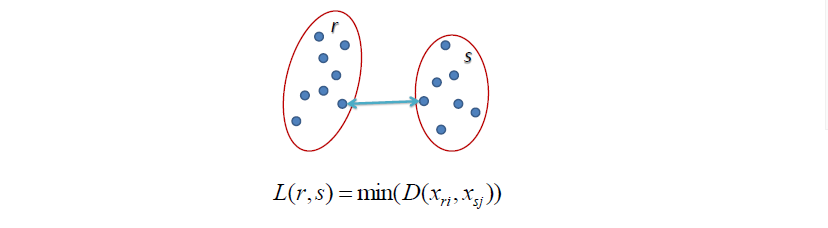

**Complete Linkage**		
In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

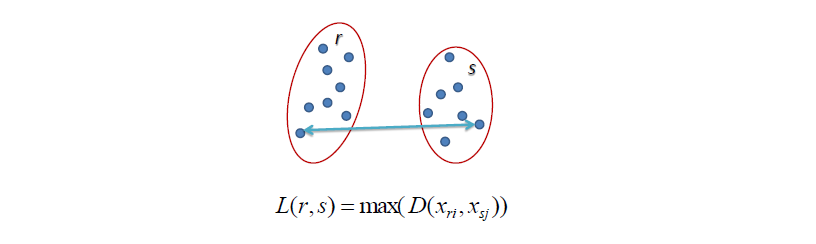

**Average Linkage**		
In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.


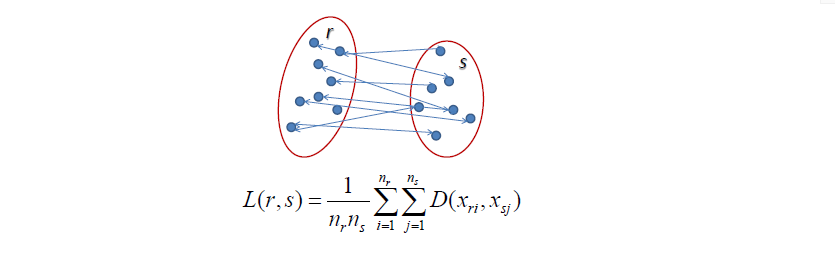

**Dendrogram: It is a convenient graphic to display a hierarchical sequence of clustering assignments.**
This is simply a tree where:
- Each node represents a group.
- Each leaf node is a singleton (i.e., a group containing a single data point)
- Root node is the group containing the whole data set.
- Each internal node has two daughter nodes (children), representing the the groups that were merged to form [it](https://www.stat.cmu.edu/~ryantibs/datamining/lectures/05-clus2.pdf)

### Let's create the Hierarchical Clusters using Complete Linkage and visualise the Dendogram.

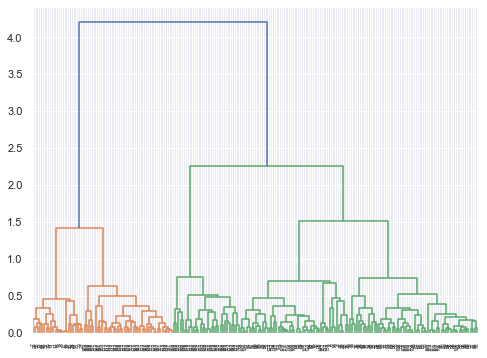

In [24]:
plt.figure(figsize=(8,6))
mergings = linkage(X, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [25]:
cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, ) #cut the tree to keep upto 5 clusters.
cluster_labels

array([0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 0, 1,
       2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1,
       2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 3, 3, 0, 3, 4, 3, 4, 3, 4, 3,
       0, 3, 0, 3, 4, 3, 0, 3, 4, 3, 0, 3, 0, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 2, 3, 0, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3])

In [26]:
X['cluster_labels'] = cluster_labels
X.head()

,Age,Annual Income (k$),Spending Score (1-100),cluster_id,cluster_labels
0,0.019231,0.000000,0.387755,0,0
1,0.057692,0.000000,0.816327,3,1
2,0.038462,0.008197,0.051020,0,0
3,0.096154,0.008197,0.775510,3,1
4,0.250000,0.016393,0.397959,0,0


### <font color=blue> Cluster Visualization </font>

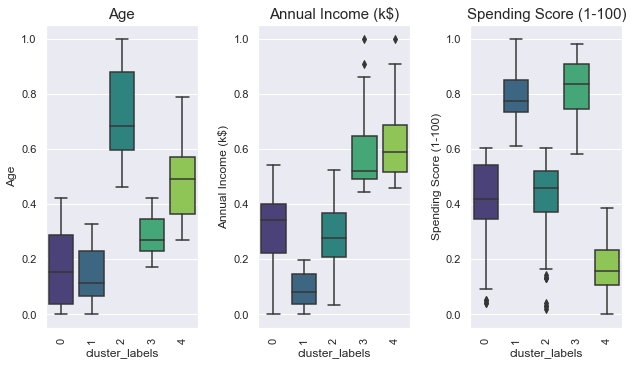

In [27]:
fig = plt.figure(figsize=(10,20))
sns.set(font_scale=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(len(X.columns)-2):
    plt.subplot(3,3, i + 1)
    ax=sns.boxplot(y=X.columns[i], x='cluster_labels', data=X,palette = 'viridis')
    ax.set_title(str(X.columns[i]), fontsize=15)
    plt.xticks(rotation=90)
fig.show()

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

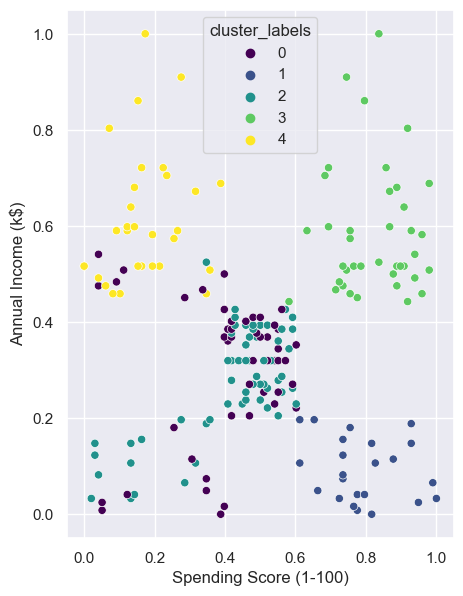

In [28]:
plt.figure(figsize=(5,7), dpi=100)
sns.scatterplot(data=X, y="Annual Income (k$)",x="Spending Score (1-100)", hue="cluster_labels", palette="viridis")

### <font color=blue> Model Evaluation </font>

In [29]:
cluster_label = cluster_labels
silhouette_avg_H = round(silhouette_score(X, cluster_label),4)
print(f"For n_clusters=5, the silhouette score is {silhouette_avg_H}")

For n_clusters=5, the silhouette score is 0.8746


## <font color=blue> DBSCAN </font>

**The Algorithm**


To find a cluster, DBSCAN starts with an arbitrary point p and retrieves all points density-reachable from p wrt. Eps and MinPts. If p is a core point, this procedure yields a cluster wrt. Eps and MinPts. If p is a border point, no points are density-reachable from p and DBSCAN visit the next point of the database.

**EPS** : EPS is a distance parameter that defines the radius to search for nearby neighbours. We can imagine each data point having a circle with radius EPS drawn around it. 

The value of EPS taken to cluster the data has a significant impact on the results. If the value of EPS is considered too small, decidedly fewer data points will be considered in one cluster, and a large part of the data will not be clustered. The un-clustered data points will be considered as outliers because they don't satisfy the number of points to create a dense region. If the EPS value is chosen to be very high, no real clusters will be formed as all of them will merge in the same cluster. The eps should be chosen based on the distance of the dataset (we can use a k-distance graph to find it), but in general small eps values are preferable.

 

**Min Samples** : Min Samples or Min Points are the number of minimum points to form a dense region or cluster. For example, if we set the min_samples as 5, we need at least 5 points to form a dense cluster. 

Minimum points can be selected from some dimensions (D) in the data set, as a general rule min points >=D+1. 

Let's build the dbscan model but before that to lets find the eps value.

In [30]:
outlier_percent = []
number_of_outliers = []

for eps in np.linspace(0.001,10,100):
    
    # Create Model
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(X)
    
    # Log Number of Outliers
    number_of_outliers.append(np.sum(dbscan.labels_ == -1))
    
    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

(0.0, 1.0)

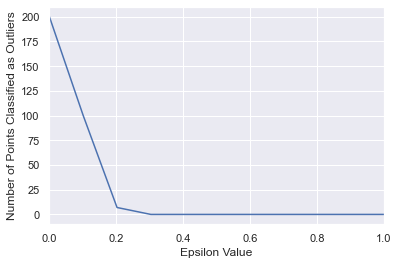

In [31]:
sns.lineplot(x=np.linspace(0.001,10,100),y=number_of_outliers)
plt.ylabel("Number of Points Classified as Outliers")
plt.xlabel("Epsilon Value")
plt.xlim(0,1)

Let's proceed with 0.3 as the eps value. Also considering the data volume we we take twice the number of data dimensions as min_samples.

In [32]:
data_dim = 3
min_samples = 2*data_dim


In [33]:
dbscan = DBSCAN(eps=0.3,min_samples=min_samples)

In [34]:
dbscan.fit(X)

DBSCAN(eps=0.3, min_samples=6)

In [35]:
X["dbscan_cluster"]=dbscan.labels_

In [36]:
X["dbscan_cluster"].value_counts()

2    58
1    49
3    40
4    30
0    23
Name: dbscan_cluster, dtype: int64

### <font color=blue> Cluster Visualization </font>

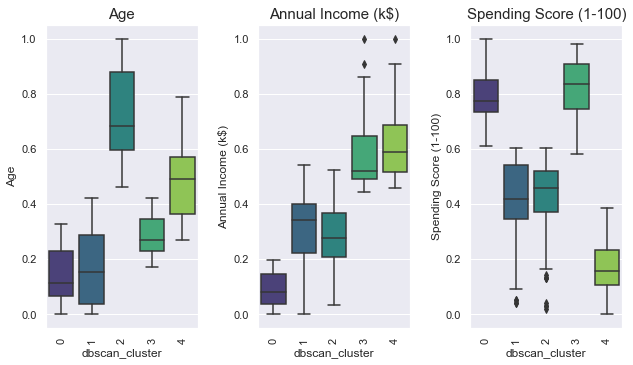

In [37]:
fig = plt.figure(figsize=(10,20))
sns.set(font_scale=1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(len(X.columns)-3):
    plt.subplot(3,3, i + 1)
    ax=sns.boxplot(y=X.columns[i], x="dbscan_cluster", data=X,palette = 'viridis')
    ax.set_title(str(X.columns[i]), fontsize=15)
    plt.xticks(rotation=90)
fig.show()

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

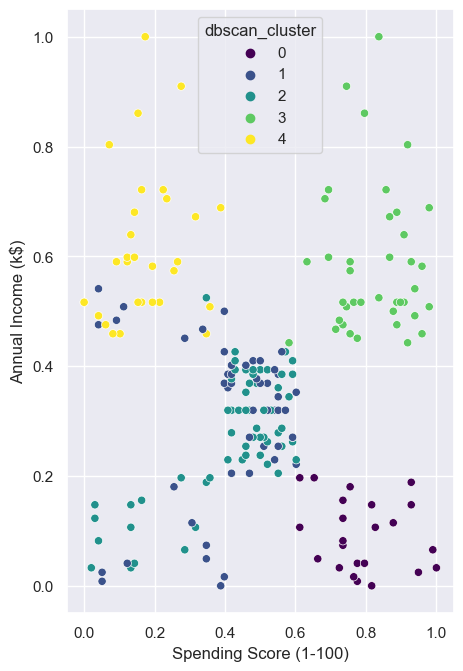

In [38]:
plt.figure(figsize=(5,8), dpi=100)
sns.scatterplot(data=X, y="Annual Income (k$)",x="Spending Score (1-100)", hue="dbscan_cluster", palette="viridis")

### <font color=blue> Model Evaluation </font>

In [39]:
dbscan_cluster=dbscan.labels_
silhouette_avg_db = round(silhouette_score(X, dbscan_cluster),4)
print(f"For dbscan model, the silhouette score is {silhouette_avg_db}")

For dbscan model, the silhouette score is 0.8877


In [40]:
Models = ["K-Means Clustering", "Hierarchical Clustering", "DBSCAN"]
Silhouette = [silhouette_avg_K,silhouette_avg_H, silhouette_avg_db ]

## <font color=green> Conclusions </font>


- From Hopkins statistic, it was observed that the data showed considerable clustering tendency. 
- The data was analysed through K-means, hierarchical & DBSCAN clustering algorithms.
- The model was evaluated by using Silhoutte score as a metric. The results can be seen below:

In [41]:
df = pd.DataFrame(list(zip(Silhouette)), columns=["Silhouette Score"], index=Models)
df


,Silhouette Score
K-Means Clustering,0.7504
Hierarchical Clustering,0.8746
DBSCAN,0.8877


Thus for the given dataset DBSCAN performs slightly better in forming clusters. From the scatterplot five clusters can be interpreted as:
- High income - High spending customers.
- High income - Low spending customers.
- Mid income  - Mid spending customers.
- Low income  - High spending customers.
- Low income  - Low spending customers.

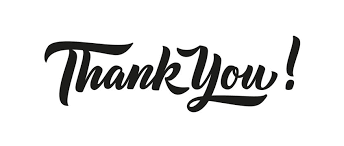